# Proyecto final Data Science
# Por Gabriel Jáuregui y Facundo Lubo




## 12 años desde la creación de la ley de salud mental argentina. Un estudio de procesamiento de lenguaje natural.
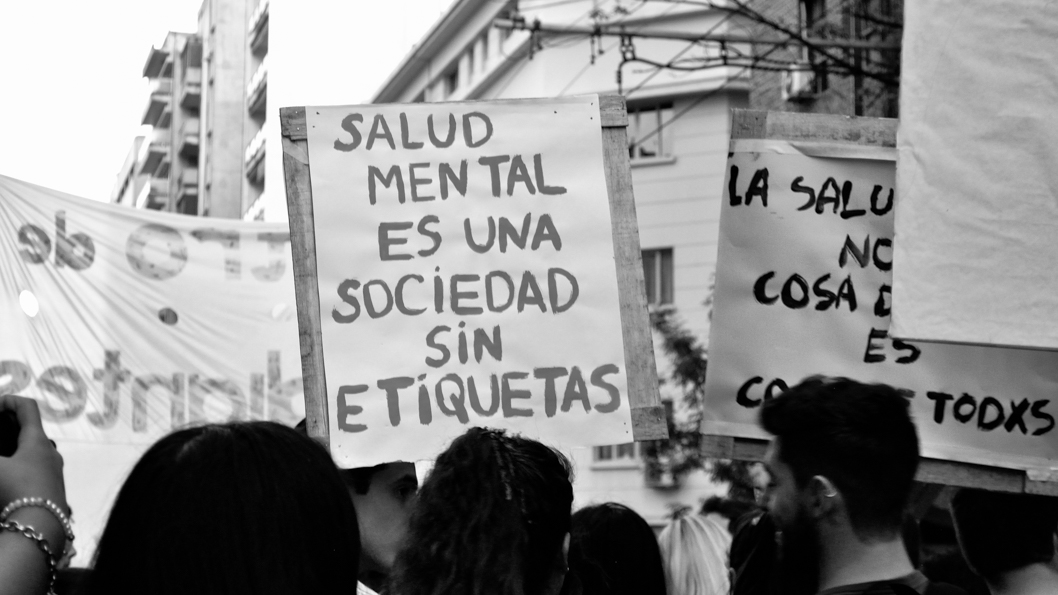
##### Imagen de una marcha de salud mental en Buenos (La tinta, 2020)

## El 10 de Octubre, se celebró el día de la salud mental en Argentina. ¿Qué pensás sobre este tema? En argentina tenemos una ley de salud mental, que es la 26,657.

####  Somos Gabriel Jáuregui y Facundo Lubo, dos psicólogos argentinos interesados en saber qué piensa la población sobre esta temática en nuestra región.

#### En el curso de Data Science de Coder House aprendimos a trabajar con todo tipo de información. En este caso, nos conectamos a la API  de Twitter para descargar todos los tweets que nombraban "ley de salud mental" desde 2010 hasta junio de 2022. Luego nos centramos en realizar lo que se conoce como "analisis de sentimiento". ¿Te imaginás qué encontramos? 


### Acompañanos a ver cómo fuimos trabajando este proyecto, desde la generación de nuestra propia base de datos hasta su limpieza y la esperada generación de inferencias e interpretaciones.

### Te vamos adelantando que ¡encontramos más de 72 mil tweets sobre este tema! 




In [ ]:
# Comenzamos importando librerías y herramientas

# Operaciones básicas 
import pandas as pd
import numpy as np

# Operaciones estadísticas
import scipy.stats

# Trabajo con fechas
import time

# Generación de gráficos 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

# Generación de nubes de palabras
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Para trabajar con google drive y el sistema operativo
import re
import os
from os import path
from google.colab import files
from google.colab import drive

#Realización de mapas interactivos
import folium
from folium.plugins import HeatMap

#Trabajo con datos nulos
import missingno as msno

In [ ]:
#Configuraciones de Pandas para tener mayor comodidad al revisar los datos ya que queríamos ver con detenimiento el texto de los tweets
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', None)

## A continuación, un ejemplo de cómo fuimos creando y conformando lo que sería nuestro dataset para el proyecto final


In [ ]:
!pip install tweepy #Primero instalamos la librería Tweepy
import tweepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Nos fijamos de cumplir con todos los términos y condiciones legales del uso de la API
#También estuvimos en contacto con el equipo de twitter para developers para poder conseguir acceso para investigadores, lo cual nos permite ahora traernos hasta 10 millones de tweets por mes


#Luego, nos conectamos a la API y comenzamos a realizar queries o consultas para traernos información.

#Con este método creamos la variable cliente para acceder con el Token
client = tweepy.Client(bearer_token=BEARER_TOKEN, wait_on_rate_limit=True) 

salud_mental_tweets = [] #Creamos una lista vacía donde alojaremos los tweets

#Por cada response que nos ofrezca el paginator, agregaremos a la lista (con append hacia el final de la iteración) un tweet
#Asimismo, estamos definiendo una query, y unas listas con los campos de: usuario, tweet, expansiones. 
#También incluímos una fecha de inicio de búsqueda y una de finalización. Twitter no nos deja hacer consultas con este método que sean mayores a 30 días.
for response in tweepy.Paginator(client.search_all_tweets, 
                                 query = '"Ley de Salud Mental" -is:retweet lang:es',
                                 user_fields = ['username', 'public_metrics', 'description', 'location'],
                                 tweet_fields = ['created_at', 'geo', 'public_metrics', 'text'],
                                 expansions = 'author_id',
                                 start_time = '2022-06-02T00:00:00Z',
                                 end_time = '2022-07-01T00:00:00Z',
                              max_results=500):
    time.sleep(1) #Esto se agrega para que no se exceda el límite de requests por segundo
    salud_mental_tweets.append(response) #Agregamos la response a la lista de tweets

AttributeError: ignored

## Luego de conformar muchos archivos csv con la infornmación que twiter nos concedió (twitter sólo te deja hacer queries de hasta 30 días) hicimos un merge de todos los csv, para llegar finalmente a nuestro dataset, que luego fuimos también limpiando quitando por ejemplo tweets repetidos


In [ ]:
#Nos conectamos al drive y cargamos nuestro csv con los tweets sobre la nueva ley de salud mental argentina

drive.mount("/content/gdrive", force_remount=True)
path = "/content/gdrive/MyDrive/Entregas DS Coder house/13va Entrega/saludmental+analisis.csv"

#Creación de Pandas Data Frame leyendo nuestro archivo CSV
df = pd.read_csv(path, parse_dates = ['created_at'])

df.drop(labels=['Subjectivity', 'Polarity', 'Sentiment_analysis'], axis=1, inplace= True)
#Mostramos un ejemplo de nuestro dataset
df.head(5)

Mounted at /content/gdrive


,author_id,username,author_followers,author_tweets,author_description,author_location,text,created_at,retweets,replies,likes,quote_count
0,162018366.0,yagodinella,1276,10415,Criminólogo y desmanicomializador / Psicoloco ...,Viedma,"Dicen q puede haber un paro de electroshocks, ...",2010-11-30 22:29:38+00:00,0,0,0,0
1,162018366.0,yagodinella,1276,10415,Criminólogo y desmanicomializador / Psicoloco ...,Viedma,el jueves 18 horas la ley de salud mental tend...,2010-11-30 22:12:40+00:00,1,0,0,0
2,20812292.0,lukekolifa,1247,37003,🇦🇷✌️ cambiar no es resignar.\nmi meta es cada ...,C. A. de Buenos Aires,@eliooses nosotros avalamos solamente en ciert...,2010-11-30 21:56:35+00:00,1,0,0,0
3,50428688.0,rogeliocasado,791,29376,militante das causas (im)possíveis,Manaus-Amazonas-Brasil,Argentina: El Senado sancionó la nueva Ley de ...,2010-11-30 18:24:32+00:00,0,0,0,0
4,50428688.0,rogeliocasado,791,29376,militante das causas (im)possíveis,Manaus-Amazonas-Brasil,Argentina sancionó la nueva Ley de Salud Menta...,2010-11-30 12:43:11+00:00,0,0,0,0


In [ ]:
df.columns

Index(['author_id', 'username', 'author_followers', 'author_tweets', 'author_description', 'author_location', 'text', 'created_at', 'retweets', 'replies', 'likes', 'quote_count'], dtype='object')

In [ ]:
df.shape

(85744, 12)

Vemos que con las aclaraciones que fuimos haciendo al pedir la información de la API, tenemos 12 columnas. La más importante sería "text" que nos trae el texto de cada tweet, pero también encontraríamos otras variables relevantes como los likes o los retweets. Al principio la base se constituyó de 85744 tweets.

# Exploratory data analysis: 
## En esta parte del proceso realizamos una exploración de los datos, como ver cuáles son las estadísticas descriptivas de algunas variables, y ver si tenemos algún problema en nuestro dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85744 entries, 0 to 85743
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   author_id           85744 non-null  float64            
 1   username            85744 non-null  object             
 2   author_followers    85744 non-null  int64              
 3   author_tweets       85744 non-null  int64              
 4   author_description  74404 non-null  object             
 5   author_location     60968 non-null  object             
 6   text                85744 non-null  object             
 7   created_at          85744 non-null  datetime64[ns, UTC]
 8   retweets            85744 non-null  int64              
 9   replies             85744 non-null  int64              
 10  likes               85744 non-null  int64              
 11  quote_count         85744 non-null  int64              
dtypes: datetime64[ns, UTC](1), float

In [ ]:
df.describe()

,author_id,author_followers,author_tweets,retweets,replies,likes,quote_count
count,8.574400e+04,8.574400e+04,8.574400e+04,85744.000000,85744.000000,85744.000000,85744.000000
mean,2.132740e+17,2.803085e+04,5.709824e+04,2.711630,0.615950,8.560926,0.182613
std,4.424066e+17,2.186113e+05,1.419538e+05,27.774178,7.333101,147.110718,2.889880
min,7.699190e+05,0.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,1.802504e+08,2.390000e+02,4.670000e+03,0.000000,0.000000,0.000000,0.000000
50%,5.155810e+08,9.180000e+02,1.628500e+04,0.000000,0.000000,0.000000,0.000000
75%,3.004362e+09,4.179250e+03,5.208000e+04,1.000000,0.000000,2.000000,0.000000
max,1.540000e+18,9.667232e+06,4.189814e+06,2712.000000,914.000000,25530.000000,325.000000


#### La siguiente matriz nos sirve para detectar si hay datos ausentes en nuestro set de datos. Vemos que la Location y la Description tienen algunos datos faltantes. Esto se debe a que, por un lado, no todas las cuentas de twitter tienen una descripción, y por otro, no todos los tweets cuentan con geolocalización 


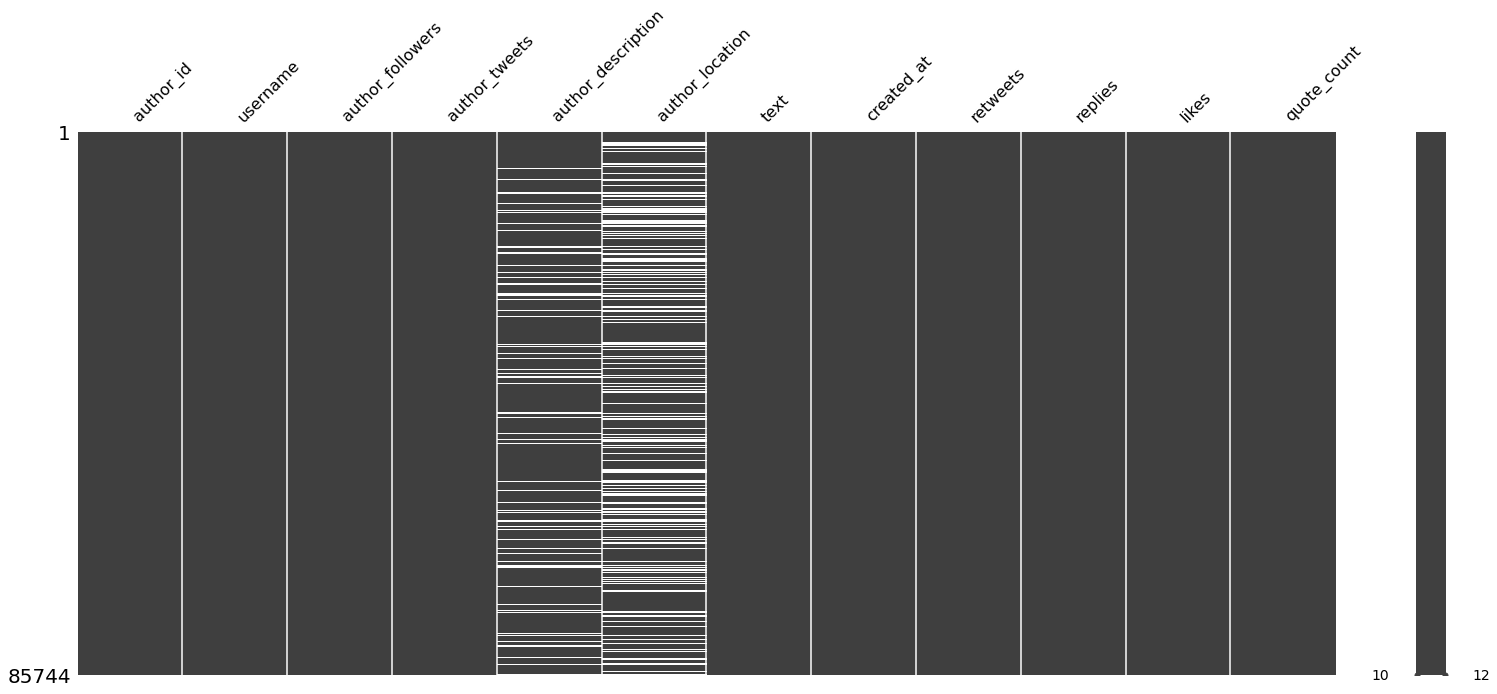

In [ ]:
 msno.matrix(df)

In [ ]:
df.isna().sum()

author_id                 0
username                  0
author_followers          0
author_tweets             0
author_description    11340
author_location       24776
text                      0
created_at                0
retweets                  0
replies                   0
likes                     0
quote_count               0
dtype: int64

Específicamente, tenemos 11,340 datos faltantes en las descripciones de las cuentas, y 24,776 datos faltantes en la localización de los autores. Pensamos que si bien la API de twitter nos provee esta información sobre las descripciones de las cuentas, probablemente no utilicemos esa información, por lo que podemos eliminar esa columna del dataset más adelante

#####Aquí realizamos una exploración de correlaciones entre las variables utilizando la funcion 'df.corr()' pero anidandola en un gráfico: 

#####Esto nos permite obtener más rápidamente información que antes obtuvimos en varios pasos, relativa a la alta correlacion entre likes y retweets, así como a la correlacion significativa entre retweets, replies, likes, quote_count entre si.

##### Asimismo, aunque no sea tan significativo, vemos que la cantidad de Followers se sigue de un aumento en la cantidad de Tweets

Por último, en este heat map de correlaciones vemos que la mejor correlación que hay en este dataset sería la de los likes vs los retweets, casualmente la primera que intentamos graficar. Otra correlación que nos viene resultando interesante, si bien es más baja, es la de los followers que tiene un autor con la cantidad de tweets producidos, esto podría llevarnos a pensar que, a mayor actividad de un autor, más es el seguimiento que tiene esa cuenta


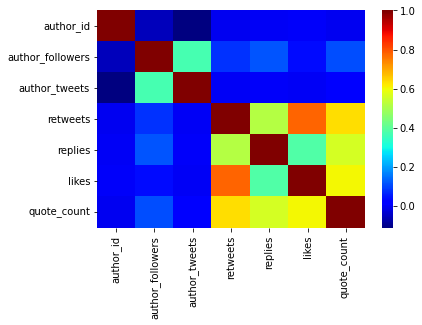

In [ ]:
sns.heatmap(df.corr(), cmap='jet')

Mapeo de los usuarios con mas tweets.


In [ ]:
print(df['username'].value_counts().head(15))
print('\n')
print(df['username'].value_counts().median())
print('\n','Moda: ')
print(df['username'].value_counts().mode())

elantidroga        870
gustavolew         266
radiovilardevoz    250
leogorbacz         218
azevallos          176
fernandapaolini    172
RadioCutFm         160
AlbaLuzPinilla     140
ladiaria           124
CongresoEdoSLP     120
SomosKaluyMoro     118
gauchiurbano       114
ConsultaConJCB     110
GraceJusticia       96
robteeusss          88
Name: username, dtype: int64


2.0

 Moda: 
0    2
dtype: int64


**¡Resulta muy interesante que año a año aumentan los tweets sobre este tema!**

Si bien aquí pareciera que en 2021 se produjeron más tweets que en 2022, eso se debe a que cuando nos conectamos a la API de twitter a buscar los datos, estabamos cursando el mes de Junio, motivo por el cual faltarían varios meses de datos del 2022


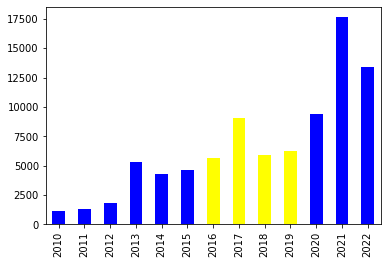

In [ ]:
df['created_at'].dt.year.value_counts().sort_index().plot.bar(color=['blue','blue','blue','blue','blue','blue','yellow','yellow','yellow','yellow']) #Años con mas tweets

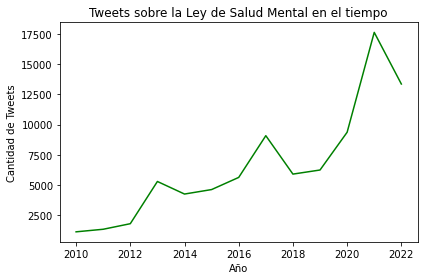

In [ ]:
tweet_date_year = df['created_at'].dt.year.value_counts().sort_index().index
cant_tweets_year = df['created_at'].dt.year.value_counts().sort_index()
plt.plot(tweet_date_year, cant_tweets_year, color= 'green')
plt.title('Tweets sobre la Ley de Salud Mental en el tiempo')
plt.xlabel('Año')
plt.ylabel('Cantidad de Tweets')
plt.tight_layout()
plt.show()

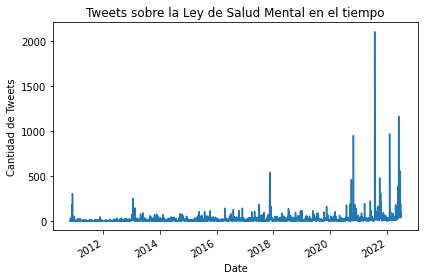

In [ ]:
tweet_date = df['created_at'].dt.date.value_counts().sort_index().index 
cant_tweets = df['created_at'].dt.date.value_counts().sort_index()

plt.plot(tweet_date, cant_tweets)
plt.gcf().autofmt_xdate()

plt.title('Tweets sobre la Ley de Salud Mental en el tiempo')
plt.xlabel('Date')
plt.ylabel('Cantidad de Tweets')

plt.tight_layout()

plt.show()

Observamos que los meses de Noviembre y Julio tienen más Tweets. Por un lado, tiene sentido que Noviembre sea el primer valor porque es considerado 'Mes de la Salud Mental'. No obstante, sería interesante explicar porque Mayo-Junio-Julio tienen tantas ocurrencias**

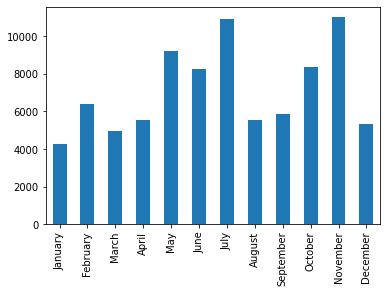

In [ ]:
df['created_at'].dt.month_name().value_counts(sort=False)[[2,3,4,5,6,7,8,1,9,10,0,11]].plot.bar() #Meses con mas tweets

La mitad de los días contemplados (N=3814) se escribieron entre 6 y 20 tweets. Asimismo, con una mediana de 12 y una moda de 4, vemos que el promedio de 22 tweets está claramente distorsionado por días donde se tweeteo mucho (¡Desvio estandar de 66!)

In [ ]:
print(df['created_at'].dt.date.value_counts().describe())
print('\n','Moda---')
print(df['created_at'].dt.date.value_counts().mode()) #Moda = 4
print('\n','Curtosis(obtained using Fisher’s definition of kurtosis (kurtosis of normal == 0.0). Normalized by N-1)')
df['created_at'].dt.date.value_counts().kurt(axis=0)

count    3814.000000
mean       22.481384
std        66.692703
min         2.000000
25%         6.000000
50%        12.000000
75%        20.000000
max      2104.000000
Name: created_at, dtype: float64

 Moda---
0    4
dtype: int64

 Curtosis(obtained using Fisher’s definition of kurtosis (kurtosis of normal == 0.0). Normalized by N-1)


401.6474760934269

En cuanto a la Nacionalidad, vemos a simple vista que el 25% superior de las ubicaciones más frecuentes, concentra más del 80% de los tweets. Por lo que haremos estimaciones provisorias con esos valores extremos.

In [ ]:
df['author_location'].value_counts().describe()

count    6591.000000
mean        9.250190
std        78.501385
min         2.000000
25%         2.000000
50%         2.000000
75%         4.000000
max      4508.000000
Name: author_location, dtype: float64

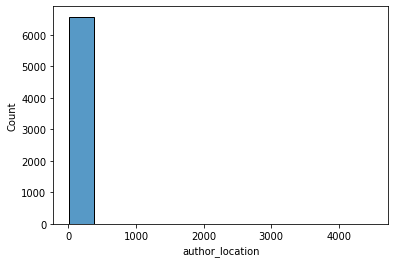

In [ ]:
sns.histplot(data= df['author_location'].value_counts(), bins=12)

In [ ]:
df['author_location'].value_counts().head(30) 

Argentina                         4508
Buenos Aires, Argentina           2730
Ciudad Autónoma de Buenos Aire    1898
Buenos Aires                      1236
Buenos Aires - Argentina          1044
México                             912
Córdoba, Argentina                 868
Montevideo, Uruguay                802
Uruguay                            700
Chile                              678
argentina                          618
La Plata, Argentina                546
Rosario, Argentina                 470
Lima, Peru                         432
España                             414
Santiago, Chile                    396
CABA                               356
Ciudad de Buenos Aires             356
Colombia                           346
Panamá                             308
Mar del Plata, Argentina           298
El Salvador                        292
Mendoza, Argentina                 290
Caba                               288
Madrid                             282
La Plata                 

Vemos que de las 30 ubicaciones con mayor cantidad de tweets, las que son de Argentina, representan cerca del 60%. Nos surge la idea en el futuro de transpolar esto a un grafico tipo mapa del país para poder transmitir información de cuál es la provincia por ejemplo que más ha participado en este debate en Twitter, o cuál es el tono emocional de cada provincia. Pronto haremos un gráfico de mapa para visualizar mejor este tema!

In [ ]:
print('Argentina: ')
print(df['author_location'].value_counts()[[0,1,2,3,4,6,10,11,12,16,17,20,21,23,25,27]].sum()) #Argentina
print('No argentina: ')
print(df['author_location'].value_counts()[[5,7,8,9,13,14,15,18,19,22,24,26,28,29]].sum()) #No argentina

Argentina: 
16012
No argentina: 
6264


No obstante, intentaremos analizar el resto de las localidades. Para ellos cargamos un CSV con información de todas las localidades de Argentina, con el objetivo de analizar las ocurrencias dentro del país, e intentando estimar el peso de cada Provincia y cada Localidad. También tendremos que analizar en el futuro detenidamente estos tweets, y revisar si hablan de la ley argentina, o si están hablando de otra ley de salud mental, y, en ese caso, quitarlos del dataset. De esta manera vemos que a medida que exploramos distintas dimensiones de los datos, aparecen nuevas razones para pulir la información, y nuevos aprendizajes.


In [ ]:
pathLoc = "/content/gdrive/MyDrive/Entregas DS Coder house/Cuarta entrega/localidades.csv"

locDf = pd.read_csv(pathLoc)
locDf = locDf.iloc[:,[11, 6, 10,3, 13, 12]]

locDf.iloc[:,3] = locDf.iloc[:,3].convert_dtypes(convert_string= True) #Como el dpto_id era un float con decimales y no podía usarlo...
locDf.iloc[:,3].convert_dtypes(convert_integer= True) #Decidi pasarlo a string, borrando el decimal automaticamente, para luego pasarlo a int...

locDf.iloc[:, [0,2,4]] = locDf.iloc[:, [0,2,4]].convert_dtypes(convert_string= True)
locDf.head(5)

,nombre,id,municipio_nombre,departamento_id,provincia_nombre,provincia_id
0,ALBERTI,6021010000,Alberti,6021,Buenos Aires,6
1,CORONEL SEGUI,6021020000,Alberti,6021,Buenos Aires,6
2,MECHITA,6021030000,Alberti,6021,Buenos Aires,6
3,PLA,6021040000,Alberti,6021,Buenos Aires,6
4,VILLA GRISOLIA,6021050000,Alberti,6021,Buenos Aires,6


En la siguiente ventana de código buscamos analizar las veces que coincide una location que contiene la lista completa de ciudades argentinas con una location de nuestro DF.
Si bien nos parece aproximado creemos que sigue teniendo un margen considerable de error ya que hay ciudades que se repiten en distintos países. Por ejemplo, hay ciudades como la ciudad de "Puerto Rico", Misiones, Argentina, que inevitablemente añade toda coincidencia con Puerto Rico (país)

Este método nos arroja un total de más de 43mil coincidencias provenientes de Argentina. Si obviamos el dato de 22mil entradas nulas, tenemos que aproximadamente el 70% de los usuarios son Argentinos

In [ ]:
cantArg = 0
for location2 in locDf['nombre']:
  for location1 in df['author_location'].value_counts().index:
    if location2.lower() in location1.lower():
      cantArg += df['author_location'].value_counts()[location1]
      #print("Sumamos...", df['author_location'].value_counts()[location1], "provenientes de ", location1)

print("La cantidad de coincidencias es de: ", cantArg)

# Argentina = 43815


La cantidad de coincidencias es de:  43815


#  Algunas correlaciones interesantes . . .

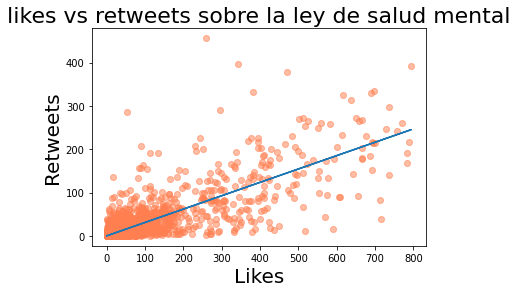

In [ ]:
#Graficamos algunas correlaciones interesantes, como para practicar un poco el más gráficos sobre analisis bivariados

df.drop(df[df['retweets'] >= 600].index, inplace = True) #removemos outliers ya que sólo 2 tweets tienen + de 600 retweets 
df.drop(df[df['likes'] >= 800].index, inplace = True) #removemos outliers ya que sólo 3 tweets tienen + de 1000 likes

# creamos nuestras variables para plotear
likes = df['likes'] 
retweets = df['retweets']
replies = df['replies']

#armamos la figura
fig1mpl, ax=plt.subplots(figsize=(6,4))
ax.scatter(likes, retweets, alpha=0.3,  c='coral')
ax.set_title('likes vs retweets sobre la ley de salud mental', fontsize=22)
ax.set_xlabel('Likes', fontsize=20)
ax.set_ylabel('Retweets', fontsize=20)

#cálculo de la ecuación para la línea de tendencia
z = np.polyfit(likes, retweets, 1)
p = np.poly1d(z)

#Agregamos linea de tendencia al gráfico
plt.plot(df['likes'], p(likes))


Del gráfico antrior podemos ver que habría una relación. A mayor cantidad de likes de un tweet, mayor la cantidad de veces que es retweeteado. A continuación, una descriptiva de las variables revisadas:

In [ ]:
#A continuación, tiramos estadística descriptiva de los likes y los retweets, vemos que la media es de 5.52 likes, aunque esto no es representativo, ya que la mayoría de los tweets tiene 0 likes, 
# esto nos sirve como ejemplo de lo visto en clase sobre que la media NO es una medida robusta

print(f'Estadística descriptiva de los likes\n', '\n', likes.describe(), ('\n'))

Estadística descriptiva de los likes
 
 count    85610.000000
mean         5.530592
std         33.608309
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        794.000000
Name: likes, dtype: float64 



In [ ]:
print(f'Estadística descriptiva de los retweets', '\n'*2, retweets.describe())

Estadística descriptiva de los retweets 

 count    85610.000000
mean         1.963532
std         12.445557
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        456.000000
Name: retweets, dtype: float64


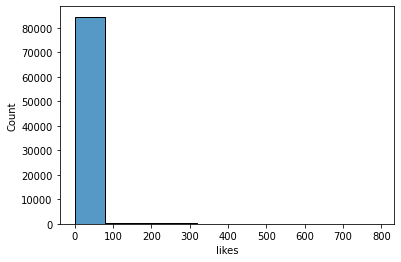

In [ ]:
# en el próximo gráfico vemos que la gran mayoría de los tweets tiene menos de 100 likes
sns.histplot(data=df, x='likes',bins=10)

In [ ]:
from scipy.stats import kstest

#Realizamos la prueba de Kolmogorov-Smirnov para nuestras variables
print('Kolmogorov-Smirnov de los likes', kstest(likes, 'norm'))
print('Kolmogorov-Smirnov de los retweets', kstest(likes, 'norm'))
print('Kolmogorov-Smirnov de los replies', kstest(likes, 'norm'))

Kolmogorov-Smirnov de los likes KstestResult(statistic=0.5, pvalue=0.0)
Kolmogorov-Smirnov de los retweets KstestResult(statistic=0.5, pvalue=0.0)
Kolmogorov-Smirnov de los replies KstestResult(statistic=0.5, pvalue=0.0)


Vemos que para todas nuestras variables, el valor p es 0,0. Como era esperable de encontrar en base al gráfico de barras. Concluímos entonces que la distribución no es normal. Ahora hemos aprendido que ante este tipo de cosas uno puede optar por normalizar los datos o no hacerlo

##### Lo que verás a continuación es una función que limpia un poco el texto de los tweets
#####Luego, utilizamos apply sobre el texto de los tweets


In [ ]:
def cleantext(text):
    text = re.sub(r'@[A-Za-z0-9]+','', text) # removemos las menciones@
    text = re.sub(r'#', '', text) # removemos el símbolo del hastag "#"
    text = re.sub(r'https?:\/\/\S+', '', text) # removemos los hyperlinks
    text = re.sub(r'\b(\w+\s)(\1+)', '\\1', text)
    text = re.sub(r'\b\w{1,5}\b', '', text) # Removemos palabras cortas

    return text
    
df_clean = df['text'].apply(cleantext) #Aplicamos nuestra función a la columna de los tweets

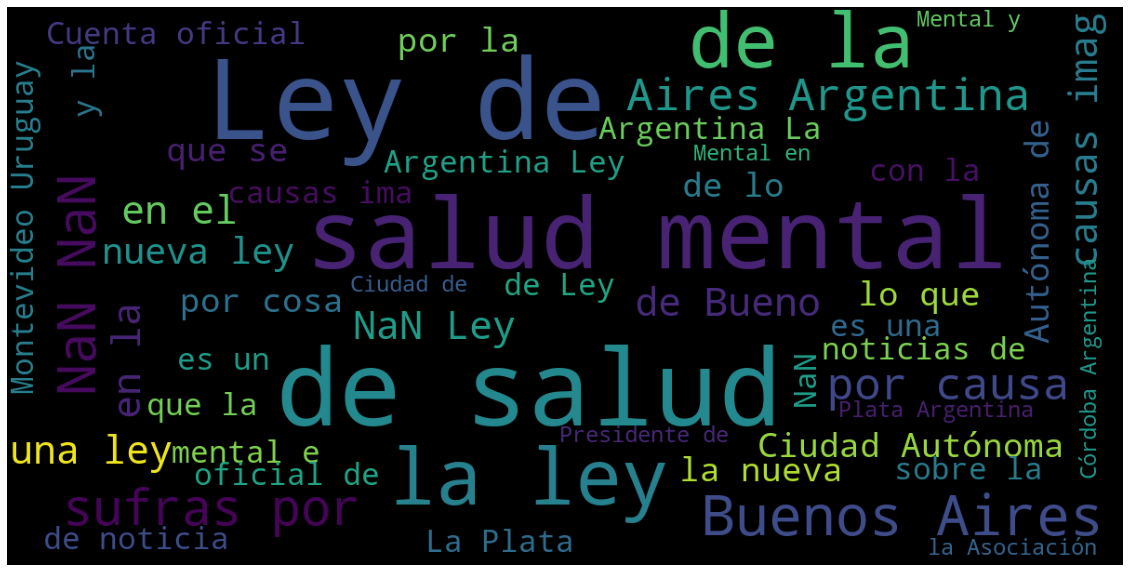

In [ ]:
import re
from PIL import Image 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator #traemos la librería para generar nubes de palabras

def Nube_AllTweets(df_clean1, title = None):
    wordcloud = WordCloud(
                background_color='black',
                stopwords = ["https", 'n', 's', 't', 'co', 'nhttps', 'Aire', 'amp', 'gt', 'lt', 'Marina'] + list(STOPWORDS), #ajustamos las stop words con algunas que no tienen sentido para esta nube luego de largar las primeras
                max_words=50,
                max_font_size=40,
                scale=3,
                random_state=1
    ).generate(str(df_clean1))
    
    fig = plt.figure(1, figsize=(20, 20))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

Nube_AllTweets(df) 

In [ ]:
#Instalamos algunas dependencias extras para cumplir con la tarea
!pip install --user -U nltk
import nltk
import re                                  # library for regular expression operations
import string                              # for string operations

from nltk.stem import SnowballStemmer        # module for stemming in spanish
from nltk.tokenize import TweetTokenizer   # module for tokenizing strings

nltk.download("popular")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

In [ ]:
# Leemos un archivo con palabras 'stopwords' en español
path = "/content/gdrive/MyDrive/Entregas DS Coder house/13va Entrega/stopwords_spanish.txt"
stopwords_serie = pd.read_fwf(path) 
stopwords_serie.rename(columns={'un':'stopwords'}, inplace=True) 

#Removemos duplicados convirtiendo el df a un set
stopwords_spanish = set(stopwords_serie['stopwords'].unique()) 

### Samples de tweets calificados en negativos  y en positivos de la librería de nltk

In [ ]:
all_positive_tweets_pd = pd.read_csv(filepath_or_buffer ='/content/gdrive/MyDrive/Entregas DS Coder house/14va entrega/pos_sample.csv', index_col= None, header=None)
all_negative_tweets_pd = pd.read_csv(filepath_or_buffer = '/content/gdrive/MyDrive/Entregas DS Coder house/14va entrega/neg_sample.csv', index_col= None, header=None)
all_positive_tweets = all_positive_tweets_pd[0].to_list()
all_negative_tweets = all_negative_tweets_pd[0].to_list()
print('Cantidad de tweets positivos: ', len(all_positive_tweets))
print('Cantidad de tweets negativos: ', len(all_negative_tweets))

Cantidad de tweets positivos:  5000
Cantidad de tweets negativos:  5000


### Seleccionamos el Training Set



* Train test split: 20% will be in the test set, and 80% in the training set.


In [ ]:
# Esta celda se podria armar aparte e importar como modulo, pero no se como hacerlo en el entorno Collab Google
def sigmoid(z):
    h = 1/(1+np.exp(-z))
    return h

class SentimentAnalisisRegLog():
  theta = np.zeros((3, 1))

  def __init__(self, train_pos, train_neg, test_pos, test_neg, learning_rate, num_iters):
    self.train_pos = train_pos
    self.train_neg = train_neg
    self.test_pos = test_pos
    self.test_neg = test_neg
    self.train_x = train_pos + train_neg
    self.test_x = test_pos + test_neg
    self.train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
    self.test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)
    self.learning_rate = learning_rate
    self.num_iters = num_iters
    self.freqs = self.build_freqs(self.train_x, self.train_y)
    # Incluimos como parte de la inicializacion de esta clase el tomar el set de entrenamiento
    # para construir una matriz 'X' con las palabras y frecuencias
    self.X = np.zeros((len(self.train_x), 3))
    for i in range(len(self.train_x)):
      self.X[i, :]= self.extract_features(self.train_x[i], self.freqs)
    # Para evitar confusiones, creamos una matriz 'Y' que toma el mismo valor que 'train_y'
    self.Y = self.train_y
    # Incluímos el entrenamiento del modelo como parte de su instanciación vía constructor
    self.apply_gradient_descent()

  #Este modulo procesa el tweet, limpiando el texto de un tweet, estemizando y tokenizando
  def process_tweet(self, tweet):
    """
    Input:
        tweet: el texto de un tweet
    Output:
        clean_tweet: una lista de palabras significativas reducidas a su raíz(stem)
    """
    #Stemmer para dejar la raíz de las palabras en español
    stemmer = SnowballStemmer('spanish')
    #Usamos expresiones regulares para extraer ruido
    tweet = re.sub(r'\$\w*', '', tweet)
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    clean_tweet = []
    for word in tweet_tokens:
        if (word not in stopwords_spanish and  
                word not in string.punctuation): 
            stem_word = stemmer.stem(word)  # stemming word
            clean_tweet.append(stem_word)

    return clean_tweet

  def build_freqs(self, train_x, train_y):
    """Diccionario de frecuencias.
    Input:
        tweets: una lista de tweets, en este caso, 'train_x'
        ys: un m x 1 array con la etiqueta de sentimiento de cada tweet (0 or 1), es decir, 'train_y'
    Output:
        freqs: un diccionario que mapea cada (palabra, sentimiento) a cada frecuencia
    """
    # Convertimos el np array a una lista dado que la función zip requiere un objeto iterable.
    # El metodo squeeze es necesario, de lo contrario la lista termina con un solo elemento

    yslist = np.squeeze(train_y).tolist()

    # Empezamos con un diccionario vacío y lo construimos loopeando a través de los tweets
    # y a través de cada palabra en cada tweet
    
    freqs = {}
    for y, tweet in zip(yslist, train_x):
        for word in self.process_tweet(tweet):
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

  def gradientDescent(self, x, y, theta, alpha, num_iters):
   
    # get 'm', the number of rows in matrix x
    m = len(x)
    
    for i in range(0, num_iters):
        
        # Obtenemos z como producto de x y theta
        z = np.dot(x, theta)
        
        # obtenemos la funcion sigmoide de z
        h = sigmoid(z)
        
        # calculamos la funcion costo
        J = - (float(1)/m) * (y.T.dot(np.log(h)) + (1-y.T).dot(np.log(1-h)))

        # actualizamos los valores de theta
        theta = theta - ((alpha/m) *  x.T.dot(h - y))
        
    J = float(J)
    return J, theta

  def extract_features(self, tweet, freqs, process_tweet=process_tweet):
    '''
    Input: 
        tweet: texto de un tweet
        freqs: un diccionario de las frecuencias de cada tupla (word, label)
    Output: 
        x: a feature vector of dimension (1,3)
    '''
    # process_tweet tokenizes, stems, and removes stopwords
    word_l = self.process_tweet(tweet)
    
    # 1 x 3 vector
    x = np.zeros((1, 3)) 
    
    # El bias en 1
    x[0,0] = 1 
    
    
    # itera en cada palabra por tweet 
    for word in word_l:
        pos_pair= (word, 1.0) #si es positiva, se almacena en esta variable
        neg_pair= (word, 0.0) #de lo contrario en esta variable
        # aumentamos la frecuencia positiva , si es el caso
        if pos_pair in freqs.keys():
            x[0,1] += freqs[pos_pair]
        
        # aumentamos la frecuencia negativa, si es el caso
        if neg_pair in freqs.keys():
            x[0,2] += freqs[neg_pair]
        
    assert(x.shape == (1, 3))
    return x



  def test_logistic_regression(self, test_x, test_y, freqs, theta):
    """
    Input: 
        test_x: una lista de tweets
        test_y: vector de tipo (m, 1) con las correspondientes etiquetas para la lista de tweets
        freqs: un dictionary correspondiente a las frecuencias de cada tupla (word, label)
        theta: vector de valores, ded dimension (3, 1)
    Output: 
        accuracy: (numero de tweets clasificados correctamente) / (total de tweets)
    """
    def predict_tweet(tweet, freqs, theta):
      '''
      Input: 
          tweet: (idem supra)
          freqs: (idem supra)
          theta: (idem supra)
      Output: 
          y_pred: la probabilidad de que un tweet sea positivo o negativo
      '''

      # guardamos en x los features
      x = self.extract_features(tweet, freqs)

      # hacemos la prediccion
      y_pred = sigmoid(np.dot(x, theta))
      
      return y_pred

    m = len(test_x)

    y_hat = []

    for tweet in test_x:
        # obtenemos la etiqueta a partir de la prediccion
        y_pred = predict_tweet(tweet, freqs, theta)
        
        if y_pred > 0.5:
            # append 1.0 a la lista
            y_hat.append(1.0)
        else:
            # append 0.0 a la lista
            y_hat.append(0.0)

    # y_hat es una lista, pero test_y es un array (m,1)
    # por lo tanto, convertimos a ambos a array unidimensional para comparar usando '=='
    y_hat = np.array(y_hat)
    y_hat = np.reshape(y_hat, (m, 1))
    
    return np.sum(y_hat == test_y)/m

  def apply_gradient_descent(self):
    self.J, self.theta = self.gradientDescent(self.X, self.Y, self.theta, self.learning_rate, self.num_iters)
    self.accuracy = self.test_logistic_regression(self.test_x, self.test_y, self.freqs, self.theta)

  def predictor_de_tweet(self, tweet):
    x = self.extract_features(tweet, self.freqs)
    y_pred = sigmoid(np.dot(x, self.theta))
    if (y_pred <= 0.5):
      return 0
    else:
      return 1

  def getAccuracy(self):
    return self.accuracy

In [ ]:
def crossValidationTweets(all_positive_tweets, all_negative_tweets, cant_chunk):
  # Dividimos los datos en dos partes, una para entrenar y otra para testear
  # Dado que los tweets positivos y negativos tienen la misma cantidad, utilizamos la misma variable para la len_chunk
  if cant_chunk < 2:
    print('cant_chunk debe ser 2 como minimo')
  len_chunk: int = int(len(all_positive_tweets)/cant_chunk)
  #Listas con n = cant_chunk sin hardCodear
  #Acá las listas suponen cant_chunk=5
  test_pos_list: list = [[] for i in range(cant_chunk)]
  train_pos_list: list = [[] for i in range(cant_chunk)]
  test_neg_list: list = [[] for i in range(cant_chunk)]
  train_neg_list: list = [[] for i in range(cant_chunk)]
  
  maxAcc = 0

  for i in range(cant_chunk):
    test_pos_list[i] = all_positive_tweets[(len_chunk * i):(len_chunk * (i+1))]
    test_neg_list[i] = all_negative_tweets[(len_chunk * i):(len_chunk * (i+1))]
    train_pos_list[i] = (all_positive_tweets[(len_chunk * (i+1)):])
    train_neg_list[i] = (all_negative_tweets[(len_chunk * (i+1)):])
    if i != 0:
      train_pos_list[i].extend(all_positive_tweets[0:(len_chunk * i)])
      train_neg_list[i].extend(all_negative_tweets[0:(len_chunk * i)])
    
    test_model = SentimentAnalisisRegLog(test_neg= test_neg_list[i], test_pos= test_pos_list[i], 
                                         train_neg= train_neg_list[i], train_pos= train_pos_list[i], 
                                         num_iters= 2000, learning_rate=1e-9) #Los parámetros son los de DeepLearning.AI
    actAccuracy = test_model.getAccuracy()
    if (actAccuracy > maxAcc):
      best_pos = i
      maxAcc = actAccuracy
      print('Best current model in iter nº ', best_pos, 'accuracy: ', maxAcc)

  return SentimentAnalisisRegLog(test_neg= test_neg_list[best_pos], test_pos= test_pos_list[best_pos], 
                                 train_neg= train_neg_list[best_pos], train_pos= train_pos_list[best_pos],
                                 num_iters= 2000, learning_rate=1e-9) #Los parámetros son arbitrarios y los copiamos del sitio DeepLearning.AI

In [ ]:
#cant_chunk es el parámetro que define en cuantas partes dividimos el dataset(en este caso el texto de los tweets)

best_model = crossValidationTweets(all_positive_tweets, all_negative_tweets, cant_chunk= 10)

Best current model in iter nº  0 accuracy:  0.7
Best current model in iter nº  2 accuracy:  0.712


In [ ]:
best_model.getAccuracy()

0.712

Vamos a intentar predecir un solo tweet

In [ ]:
if (best_model.predictor_de_tweet(df['text'][np.random.randint(82000)]) == 0):
  print('negative')
else:
  print('positive')

positive


Vamos a aplicar nuestra funcion predictor_de_tweet al DataFrame

In [ ]:
df['sentiment'] = df['text'].apply(best_model.predictor_de_tweet)

Contamos la cantidad de positivos y negativos

Cantidad de tweets Negativos y positivos
 0    50357
1    35253
Name: sentiment, dtype: int64


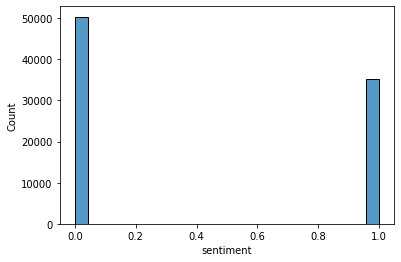

In [ ]:
import seaborn as sns
sns.histplot(df, x=df["sentiment"])
print("Cantidad de tweets Negativos y positivos\n", df["sentiment"].value_counts())

### Ahora armemos un grafico de la evolucion del sentimiento a lo largo del tiempo

In [ ]:
dates = [x for x in range (2010,2023)]
cant_neg = []
cant_pos =  []
for year in range(2010,2023):
  cant_neg.append(df['sentiment'][(df['created_at'] > str(year)) & (df['created_at'] < str(year+1))].value_counts(normalize=False).sort_index()[0])
  cant_pos.append(df['sentiment'][(df['created_at'] > str(year)) & (df['created_at'] < str(year+1))].value_counts(normalize=False).sort_index()[1])


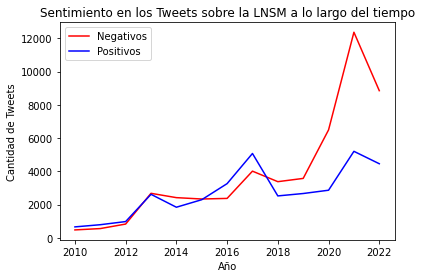

In [ ]:
sentimentGraph = pd.DataFrame({
   'Negativos': cant_neg,
   'Positivos': cant_pos
   }, index= dates)

lines = sentimentGraph.plot.line(color= ['red', 'blue'], title='Sentimiento en los Tweets sobre la LNSM '
        'a lo largo del tiempo', ylabel = 'Cantidad de Tweets', xlabel= 'Año')

Ahora realizamos un gráfico que enfatice la el ratio de positividad y de negatividad dejando un poco de lado la cantidad de tweets sobre el tema

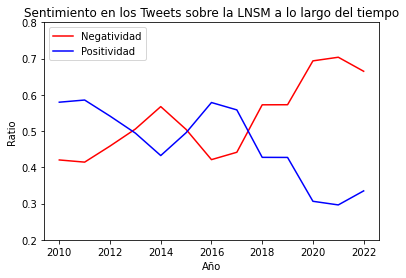

In [ ]:
cant_neg = []
cant_pos = []
for year in range(2010,2023):
  cant_neg.append(df['sentiment'][(df['created_at'] > str(year)) & (df['created_at'] < str(year+1))].value_counts(normalize=True).sort_index()[0])
  cant_pos.append(df['sentiment'][(df['created_at'] > str(year)) & (df['created_at'] < str(year+1))].value_counts(normalize=True).sort_index()[1])

sentimentGraph = pd.DataFrame({
   'Negatividad': cant_neg,
   'Positividad': cant_pos
   }, index= dates)

lines = sentimentGraph.plot.line(color= ['red', 'blue'], title='Sentimiento en los Tweets sobre la LNSM '
        'a lo largo del tiempo', ylim=(0.2, 0.8), ylabel = 'Ratio', xlabel= 'Año')

## Se detecta un patrón de inicial positividad posterior a la sanción hasta el año de la reglamentación (2010-2012) para luego descender desde 2013 a 2015. Luego tenemos dos años de reversión de la tendencia (2016-2017), que en el campo cultural y político se caracterizaron por cierta defensa de la LNSM y a favor del cierre de los Hospitales Neuropsiquiátricos Monovalentes.

## A partir de allí, se observa un marcado descenso en la positividad, llegando a hacer picos de negatividad en 2021, año caracterizado por un suceso entre el cantante Chano Charpentier y las fuerzas policiales que impulsó una fuerte crítica negativa a la LNSM y aumentó significativamente la cantidad de tweets sobre el tema

## Si bien restan análisis, la nube de palabras mostraba claramente que temas vinculados a la internación, así como al tratamiento para personas con consumo problemático de sustancias psicoactivas, son los temas más candentes y más cuestionados en torno a la LNSM.